In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
import os
PYSPARK_PYTHON ="C:/ProgramData/Anaconda3/python.exe"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [3]:
!pip install -q findspark
!pip install pyspark

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from pyspark.sql import SparkSession

In [0]:
APP_NAME = "DataFramesAndMLLib"
SPARK_URL = "local[*]"

In [0]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [8]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
!pip install --user -U nltk
!pip install --user -U numpy
import nltk

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

Requirement already up-to-date: nltk in /root/.local/lib/python3.6/site-packages (3.5)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.4)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##**Fake and real news dataset**

In [0]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import StringType, StructField, StructType
def read_data(loc):
  schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])
  df= pd.read_csv(loc)
  df= spark.createDataFrame(df, schema= schema)
  return df

In [0]:
from datetime import datetime, time
from pyspark.sql.functions import col, udf, to_date, unix_timestamp, from_unixtime,from_utc_timestamp
from pyspark.sql.types import DateType, IntegerType

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('my-cool-app') \
    .getOrCreate()

In [0]:
locationF = '/content/drive/My Drive/Colab Datasets/Fake2.csv'
locationT = '/content/drive/My Drive/Colab Datasets/True2.csv'
fake = read_data(locationF)
true = read_data(locationT)

In [13]:
fake.cube('subject').count().dropna().show()

+---------------+-----+
|        subject|count|
+---------------+-----+
|    Middle-east|  579|
|           News| 9050|
|        US_News|  775|
|       politics| 6833|
|Government News| 1568|
|      left-news| 4454|
+---------------+-----+



In [0]:
# true.cube('subject').count().dropna().show()

In [0]:
#concatenate two dataset into one
from pyspark.sql.functions import lit, rand
news= true.withColumn('label', lit('true')).union(fake.withColumn('label', lit('fake'))).orderBy(rand())
news.dropna()
# # #change date from string to date
news2 = news.withColumn('date_time', from_unixtime(unix_timestamp('date', 'MM/dd/yyyy')).cast(DateType()))
news3 =news2.na.drop(how='any')

#print('Size of Dataset', news.count())

# print('sizd of dataset:', news3.count())
# news3.show(5)

In [17]:
news3.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
| fake|23259|
| true|21417|
+-----+-----+



# **Cleaning the News Texts**

In [0]:
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer
from nltk.stem.snowball import SnowballStemmer

# 1- remove punctuation (regexp_replace), 2- tokenize, 3- remove stop words (StopWordsRemover), 4-stem (SnowballStemmer), 5- filter out short words(udf)
# 1- remove punctuation (regexp_replace)
news_clean = news3.select('title','text' , (lower(regexp_replace('text', "[^\sa-zA-Z0-9]", "")).alias('text_clean')), 'subject', 'label', 'date_time')


**Tokenizing the Text**

In [0]:
text_tokenizer= RegexTokenizer(inputCol='text_clean', outputCol='words_token', pattern= '\\W')
news_words_token = text_tokenizer.transform(news_clean).select('title', 'text_clean', 'words_token','subject', 'label', 'date_time')


**Deleting stop words**

In [0]:
del_stop = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
news_no_stop = del_stop.transform(news_words_token).select('title', 'text_clean', 'words_token','words_clean','subject', 'label', 'date_time' )


**Stematization**

In [0]:
from pyspark.sql.types import StructType, ArrayType, StringType
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
news_stemmed = news_no_stop.withColumn("words_stemmed", stemmer_udf("words_clean")).select('title', 'text_clean', 'words_token','words_clean','words_stemmed','subject', 'label', 'date_time')


**Filter out short words**

In [0]:

filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
news_final = news_stemmed.withColumn('words', filter_length_udf(col('words_stemmed')))
#news_final.show(5)


## **Exploratory Data Analysis**

**Subjects Distribution by News label**

In [0]:
from pyspark.sql.functions import count, avg
subject = news_final.groupBy('label', 'subject').agg(count('subject')).withColumnRenamed('count(subject)', 'subject_freq').sort(col("count(subject)").desc())
subject.show()

+-----+---------------+------------+
|label|        subject|subject_freq|
+-----+---------------+------------+
| true|   politicsNews|       11272|
| true|      worldnews|       10145|
| fake|           News|        9050|
| fake|       politics|        6833|
| fake|      left-news|        4454|
| fake|Government News|        1568|
| fake|        US_News|         775|
| fake|    Middle-east|         579|
+-----+---------------+------------+



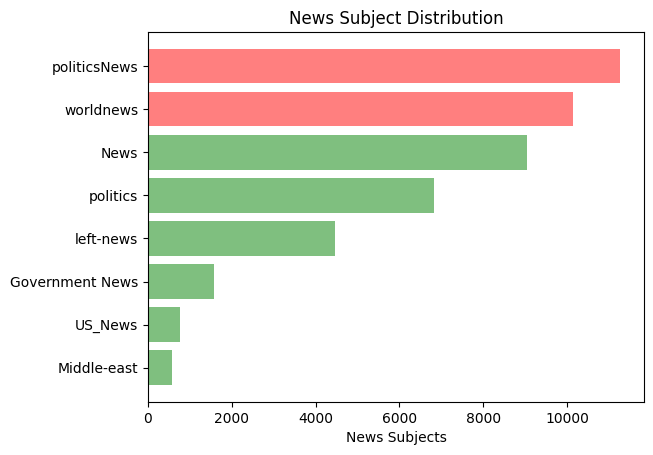

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

pd_subject = subject.toPandas()
pd_subject.sort_values('subject_freq',inplace=True)
colors = ['g','g','g','g','g', 'g', 'r', 'r']
plt.barh(pd_subject['subject'], pd_subject['subject_freq'], align='center',  alpha=0.5, color=colors)
plt.yticks(pd_subject['subject'])
plt.xlabel('News Subjects')
plt.title('News Subject Distribution')

plt.show()

In [23]:
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
# Available in PySpark >= 2.3.0 
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable  
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType


class NLTKWordPunctTokenizer(
        Transformer, HasInputCol, HasOutputCol,
        # Credits https://stackoverflow.com/a/52467470
        # by https://stackoverflow.com/users/234944/benjamin-manns
        DefaultParamsReadable, DefaultParamsWritable):

    stopwords = Param(Params._dummy(), "stopwords", "stopwords",
                      typeConverter=TypeConverters.toListString)


    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, stopwords=None):
        super(NLTKWordPunctTokenizer, self).__init__()
        self.stopwords = Param(self, "stopwords", "")
        self._setDefault(stopwords=[])
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, stopwords=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def setStopwords(self, value):
        return self._set(stopwords=list(value))

    def getStopwords(self):
        return self.getOrDefault(self.stopwords)

    # Required in Spark >= 3.0
    def setInputCol(self, value):
        """
        Sets the value of :py:attr:`inputCol`.
        """
        return self._set(inputCol=value)

    # Required in Spark >= 3.0
    def setOutputCol(self, value):
        """
        Sets the value of :py:attr:`outputCol`.
        """
        return self._set(outputCol=value)

    def _transform(self, dataset):
        stopwords = set(self.getStopwords())

        def f(s):
            tokens = [t for t in nltk.tokenize.wordpunct_tokenize(s) if t.lower() not in stopwords]
            pos_tags = nltk.pos_tag(tokens)
            return pos_tags

        t = ArrayType(ArrayType(StringType()))
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))

  

tokenizer = NLTKWordPunctTokenizer(
    inputCol="text_clean", outputCol="chk_pos",  
    stopwords=nltk.corpus.stopwords.words('english'))

news_final2 = tokenizer.transform(news_final)

news_final2.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------------------+
|               title|          text_clean|         words_token|         words_clean|       words_stemmed|     subject|label| date_time|               words|             chk_pos|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------------------+
|Lebanon passes di...|beirut reuters  l...|[beirut, reuters,...|[beirut, reuters,...|[beirut, reuter, ...|   worldnews| true|2017-10-09|[beirut, reuter, ...|[[beirut, NN], [r...|
|Fighting and air ...|geneva reuters  f...|[geneva, reuters,...|[geneva, reuters,...|[geneva, reuter, ...|   worldnews| true|2017-12-04|[geneva, reuter, ...|[[geneva, NN], [r...|
|MOCKINGBIRD REDUX...|21st century wire...|[21st, century, w...|[21st, century, w...|[21st, centuri, w...

**Frequency of POS**

In [0]:
import numpy as np
import string
import random
# define the sample size
percent_back = 0.02

# use this if you want an (almost) exact number of samples
# sample_count = 200
# percent_back = sample_count / posts.count()

frac = dict(
    (e.label, percent_back) 
    for e 
    in news_final2.select('label').distinct().collect()
)

# sample the data
sampled = news_final2.sampleBy('label', fractions=frac)


In [98]:
sampled.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
| fake|  435|
| true|  401|
+-----+-----+



In [24]:
# check_data = news_final2.select('words', 'label', 'chk_pos').limit(50)
# check_data.show(2)

+--------------------+-----+--------------------+
|               words|label|             chk_pos|
+--------------------+-----+--------------------+
|[beirut, reuter, ...| true|[[beirut, NN], [r...|
|[geneva, reuter, ...| true|[[geneva, NN], [r...|
+--------------------+-----+--------------------+
only showing top 2 rows



In [0]:
check_pd = sampled.toPandas()

In [0]:
tup_udf = udf(lambda row: [tuple(x) for x in row ], ArrayType(ArrayType(StringType())))
chk_tup= check_data.withColumn('tup_pos', tup_udf(col('chk_pos')))


In [0]:
def count_tags(text_with_tags):
    tag_count = {}
    for word, tag in text_with_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)

In [0]:
check_pd['cnt_pos'] = check_pd['chk_pos'].map(count_tags)


**True Pos**

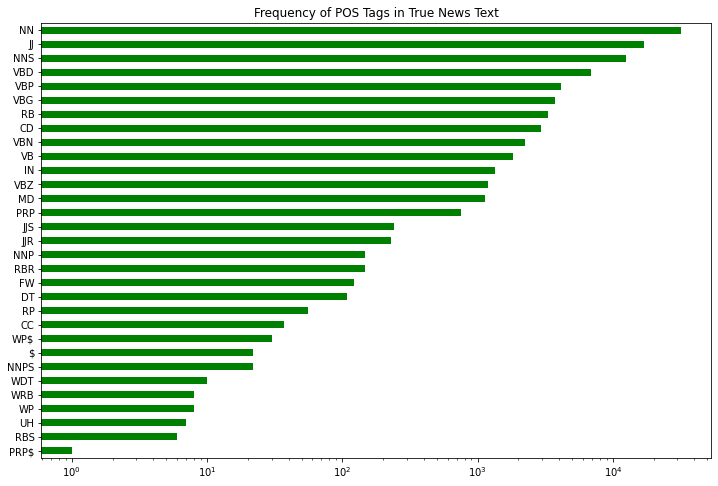

In [118]:
true_pos = check_pd.where(check_pd['label']=='true').dropna()
tag_set = list(set([tag for tags in true_pos['cnt_pos'] for tag in tags]))
for tag in tag_set:
    true_pos[tag] = true_pos['cnt_pos'].map(lambda x: x.get(tag, 0))
title = 'Frequency of POS Tags in True News Text'    

true_pos[tag_set].sum().sort_values().plot(kind='barh', logx=True, figsize=(12,8), title=title, color ='g')


In [121]:
true_pos[tag_set].sum().sort_values(ascending=False).head(10)

NN     31648
JJ     16881
NNS    12439
VBD     6936
VBP     4112
VBG     3749
RB      3334
CD      2949
VBN     2223
VB      1838
dtype: int64

**Fake Pose**

In [114]:
check_pd['label'].value_counts()

fake    435
true    401
Name: label, dtype: int64

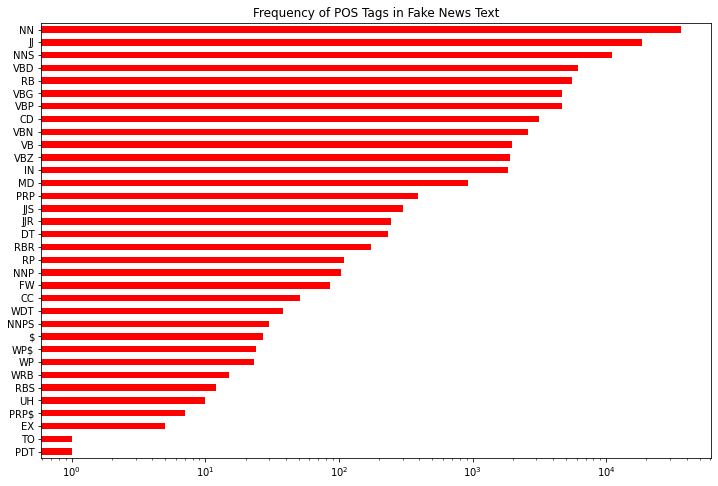

In [116]:
fals_pos = check_pd.where(check_pd['label']=='fake').dropna()
tag_set = list(set([tag for tags in fals_pos['cnt_pos'] for tag in tags]))
for tag in tag_set:
    fals_pos[tag] = fals_pos['cnt_pos'].map(lambda x: x.get(tag, 0))
title = 'Frequency of POS Tags in Fake News Text'    

fals_pos[tag_set].sum().sort_values().plot(kind='barh', logx=True, figsize=(12,8), title=title, color ='r')

In [122]:
fals_pos[tag_set].sum().sort_values(ascending=False).head(10)

NN     36066
JJ     18543
NNS    11134
VBD     6196
RB      5539
VBG     4648
VBP     4632
CD      3133
VBN     2601
VB      1960
dtype: int64

**Length of Articles Distribution**

In [24]:
import pyspark.sql.functions as f
news_length = news_final.withColumn('text_len', f.length('text_clean'))
news_length.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------+
|               title|          text_clean|         words_token|         words_clean|       words_stemmed|     subject|label| date_time|               words|text_len|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------+
|Half of central C...|goma democratic r...|[goma, democratic...|[goma, democratic...|[goma, democrat, ...|   worldnews| true|2017-10-23|[goma, democrat, ...|    2207|
| Trump Threatens ...|here s another ho...|[here, s, another...|[another, hole, l...|[anoth, hole, lea...|        News| fake|2017-03-30|[anoth, hole, lea...|    2407|
|U.S. drops some c...|washington reuter...|[washington, reut...|[washington, reut...|[washington, reut...|politicsNews| true|2017-02-27|[washington, reut...|    1615

**Text Length Discriptive Stat**

In [25]:
from pyspark.sql import Window
import pyspark.sql.functions as f

grp_window = Window.partitionBy('label')
quantiles = f.expr('percentile_approx(text_len, array(0.25, 0.5, 0.75))')

qunat = news_length.withColumn('text_len', quantiles.over(grp_window))
qunat.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----+----------+--------------------+------------------+
|               title|          text_clean|         words_token|         words_clean|       words_stemmed|        subject|label| date_time|               words|          text_len|
+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----+----------+--------------------+------------------+
| Trump Threatens ...|here s another ho...|[here, s, another...|[another, hole, l...|[anoth, hole, lea...|           News| fake|2017-03-30|[anoth, hole, lea...|[1404, 2117, 2952]|
|PHOTOS: TRUMP’S N...|president trump a...|[president, trump...|[president, trump...|[presid, trump, f...|       politics| fake|2017-10-30|[presid, trump, f...|[1404, 2117, 2952]|
| Karma’s a Bi*ch:...|they say karma s ...|[they, say, karma...|[say, karma, bich...|[say, karma, bi

In [27]:
qunat.select('label', 'text_len').distinct().show()

+-----+------------------+
|label|          text_len|
+-----+------------------+
| fake|[1404, 2117, 2952]|
| true| [892, 2168, 3156]|
+-----+------------------+



In [39]:
#mean length
mean_len = news_length.groupBy('label').agg({'text_len': 'mean'})
mean_len.show()

+-----+------------------+
|label|     avg(text_len)|
+-----+------------------+
| fake|2443.4784384539316|
| true|2323.9565765513375|
+-----+------------------+



In [42]:
type(mean_len)

pyspark.sql.dataframe.DataFrame

In [31]:
date_dist = news_final.groupBy("date_time", "label").agg({'text_clean' : 'count'}).sort(col("date_time").desc())
date_dist.show()


+----------+-----+-----------------+
| date_time|label|count(text_clean)|
+----------+-----+-----------------+
|2018-02-19| fake|                3|
|2018-02-18| fake|                7|
|2018-02-17| fake|                7|
|2018-02-16| fake|                8|
|2018-02-15| fake|                9|
|2018-02-14| fake|                1|
|2017-12-31| true|                2|
|2017-12-31| fake|                8|
|2017-12-30| fake|               15|
|2017-12-30| true|                1|
|2017-12-29| fake|               20|
|2017-12-29| true|                6|
|2017-12-28| fake|                6|
|2017-12-28| true|                5|
|2017-12-27| fake|               15|
|2017-12-27| true|               63|
|2017-12-26| true|               51|
|2017-12-26| fake|               13|
|2017-12-25| true|               40|
|2017-12-25| fake|                7|
+----------+-----+-----------------+
only showing top 20 rows



In [0]:
date_pd = date_dist.toPandas()

In [0]:
import datetime
import pandas as pd
date_pd['month'] = pd.DatetimeIndex(date_pd['date_time']).month
date_pd['year'] = pd.DatetimeIndex(date_pd['date_time']).year
text_cnt_m = date_pd.groupby(['year', 'month', 'label']).agg({'count(text_clean)':'sum'}).reset_index()
text_cnt_m["period"] = text_cnt_m["year"].astype(str) + "-" + text_cnt_m["month"].astype(str)

# selecting rows based on condition 
years = [2016, 2017]
text_cnt_sub = text_cnt_m[text_cnt_m['year'].isin(years)].sort_values(by=['period'])


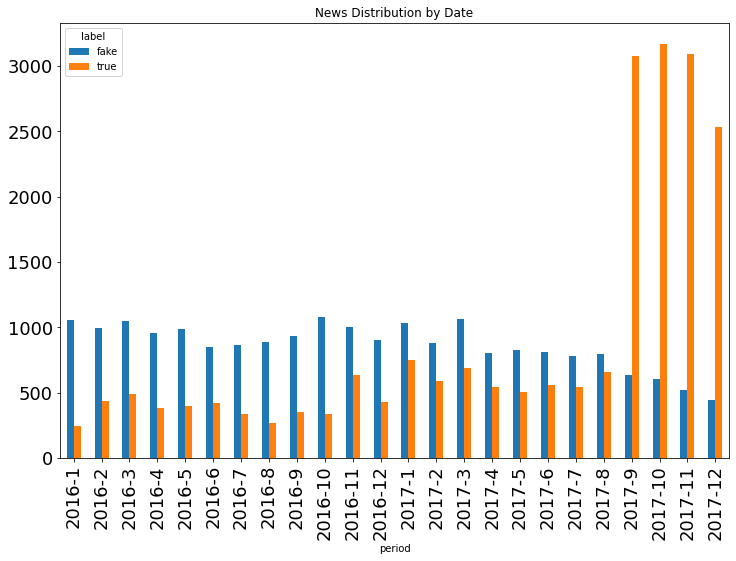

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

order = ['2016-1',	'2016-2',	'2016-3',	'2016-4',	'2016-5'	,'2016-6',	'2016-7'	,'2016-8',	'2016-9'	,'2016-10'	,'2016-11',	'2016-12',
	'2017-1',	'2017-2',	'2017-3',	'2017-4',	'2017-5',	'2017-6',	'2017-7',	'2017-8',	'2017-9',	'2017-10',	'2017-11'	,'2017-12']
text_cnt_sub.pivot("period", "label", "count(text_clean)").loc[order].plot(figsize= (12, 8), title='News Distribution by Date', fontsize= 18, kind='bar')


**n-grams by type of news**

In [0]:
import pyspark.sql.functions as f
news_text_fake = news_final2.where(f.col("label").isin({"fake"})).select('words')
news_text_true = news_final2.where(f.col("label").isin({"true"})).select('words')

In [0]:

from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
 
def build_ngrams(inputCol="words", n=3):

    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i))
        for i in range(1, n + 1)
    ]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]

    return Pipeline(stages=ngrams + vectorizers + assembler)

**Fake News Bi-Gram**

In [0]:
fake_grams = build_ngrams().fit(news_text_fake).transform(news_text_fake)
fake_grams.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               words|             1_grams|             2_grams|             3_grams|            1_counts|            2_counts|            3_counts|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|[last, debat, tru...|[last, debat, tru...|[last debat, deba...|[last debat trump...|(161518,[0,1,3,7,...|(262144,[31,49,69...|(262144,[16,342,1...|(685806,[0,1,3,7,...|
|[bad, hillari, wa...|[bad, hillari, wa...|[bad hillari, hil...|[bad hillari wasn...|(161518,[2,6,7,8,...|(262144,[1,85,170...|(262144,[972,2254...|(685806,[2,6,7,8,...|
|[holi, smoke, som...|[holi, smoke, som...|[holi smoke, smok...|[holi smoke someo...|(161518,[1,5,9,14...|(262144,[5,101,33...|(262144,[15,8133,...|(6

In [0]:
from pyspark.sql.functions import explode
cnt_bigram_fake = fake_grams.select(explode("2_grams").alias("2_grams")).groupBy("2_grams").count().sort(col("count").desc())
top_bigram_fake = cnt_bigram_fake.limit(20)

In [0]:
top_bigram_fake.show()

+--------------------+-----+
|             2_grams|count|
+--------------------+-----+
|        donald trump|15087|
|     hillari clinton| 6550|
|          white hous| 6217|
|            imag via| 6198|
|          unit state| 6027|
|            new york| 4098|
|        presid obama| 3774|
|        presid trump| 3669|
|            fox news| 3153|
|        barack obama| 2212|
|       trump support| 1984|
|        21st centuri| 1913|
|        suprem court| 1717|
|trump realdonaldt...| 1694|
|      trump campaign| 1693|
|           fake news| 1663|
|        centuri wire| 1659|
|     obama administr| 1646|
|        nation secur| 1642|
|         polic offic| 1574|
+--------------------+-----+



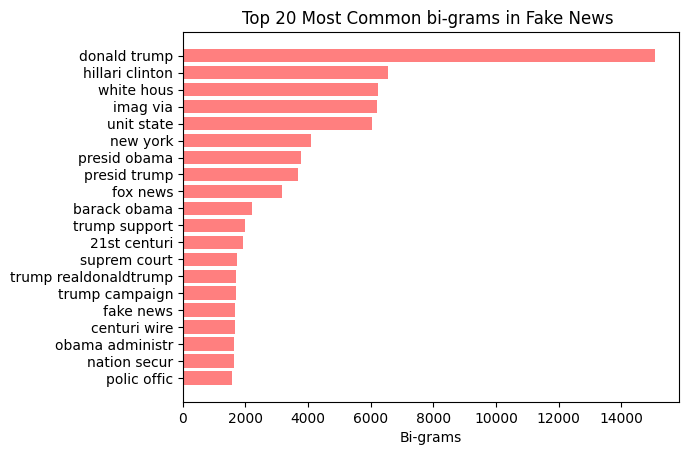

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

pd_fake = top_bigram_fake.toPandas()
pd_fake.sort_values('count',inplace=True)
plt.barh(pd_fake['2_grams'], pd_fake['count'], align='center',  alpha=0.5, color = 'r')
plt.yticks(pd_fake['2_grams'])
plt.xlabel('Bi-grams')
plt.title('Top 20 Most Common bi-grams in Fake News ')

plt.show()

In [0]:
pd_fake

,2_grams,count
0,donald trump,15087
1,hillari clinton,6550
2,white hous,6217
3,imag via,6198
4,unit state,6027
5,new york,4098
6,presid obama,3774
7,presid trump,3669
8,fox news,3153
9,barack obama,2212


**True News Bi-Gram**

In [0]:
true_grams = build_ngrams().fit(news_text_true).transform(news_text_true)
cnt_bigram_true = true_grams.select(explode("2_grams").alias("2_grams")).groupBy("2_grams").count().sort(col("count").desc())
top_bigram_true = cnt_bigram_true.limit(20)

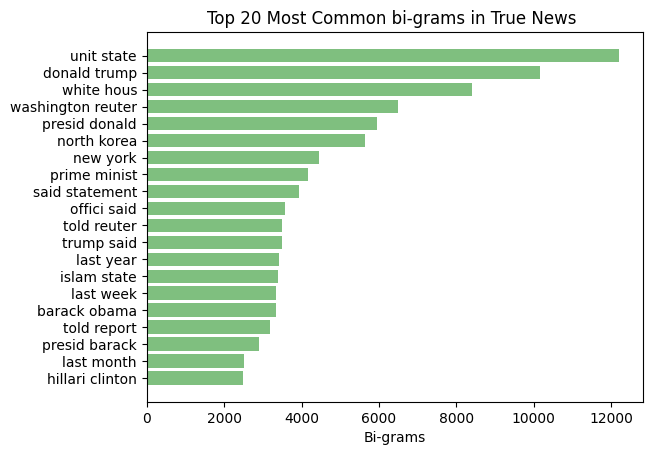

In [0]:
pd_true = top_bigram_true.toPandas()
pd_true.sort_values('count',inplace=True)
plt.barh(pd_true['2_grams'], pd_true['count'], align='center',  alpha=0.5, color ='green')
plt.yticks(pd_true['2_grams'])
plt.xlabel('Bi-grams')
plt.title('Top 20 Most Common bi-grams in True News ')

plt.show()

In [0]:
pd_true

,2_grams,count
19,hillari clinton,2492
18,last month,2510
17,presid barack,2904
16,told report,3186
15,barack obama,3341
14,last week,3345
13,islam state,3387
12,last year,3422
11,trump said,3488
10,told reuter,3492


In [0]:
# ###example to see how the above function works.
# df = spark.createDataFrame([
#   (1, ["a", "b", "c", "d"]),
#   (2, ["d", "e", "d"])
# ], ("id", "tokens"))

# build_ngrams().fit(df).transform(df).show()
# df.show()

**Count occurrence of each word**

In [0]:
import pyspark.sql.functions as f
counts = news_final.withColumn('word_count', f.explode(f.col('words')))\
    .groupBy('word_count')\
    .count()\
    .sort('count', ascending=False)
# Filter out low frequency words 
filtered = counts.filter(counts['count'] >= 5)
filtered.show()

+----------+------+
|word_count| count|
+----------+------+
|      said|129662|
|     trump|127542|
|     state| 59481|
|    presid| 55910|
|     peopl| 41021|
|republican| 37961|
|       say| 36176|
|       one| 36101|
|      year| 33223|
|      also| 30595|
|       new| 30486|
|    govern| 29182|
|      like| 29007|
|      hous| 28857|
|    report| 28798|
|    reuter| 28669|
|   clinton| 27651|
|  democrat| 27620|
|    donald| 27399|
|     obama| 27086|
+----------+------+
only showing top 20 rows



**Subset of Data for Word Cloud**

In [0]:
df_sub = filtered.limit(10000)

In [0]:
frequencies = df_sub.toPandas()

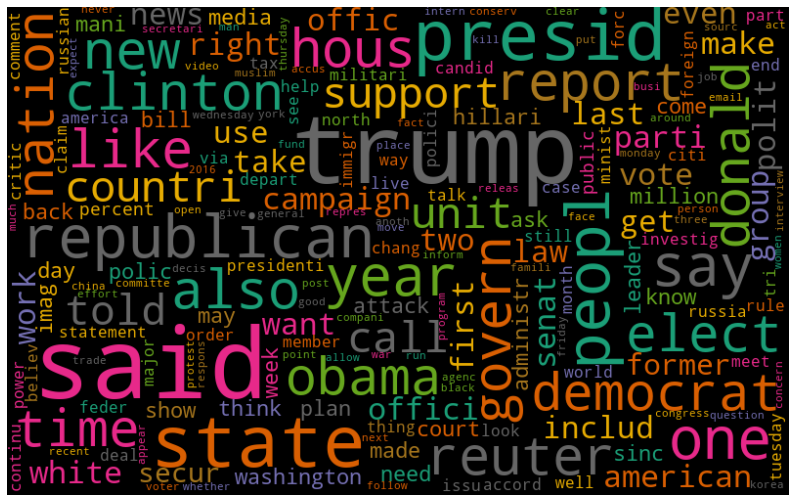

In [0]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
wordcloudConvertDF = frequencies.set_index('word_count').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [0]:
import pyspark.sql.functions as f
counts_lab = news_final.withColumn('word_count', f.explode(f.col('words')))\
    .groupBy('word_count', "label")\
    .count()\
    .sort('count', ascending=False)
filtered_lab = counts_lab.filter(counts_lab['count'] >= 5)

In [0]:
df_sub_lab = filtered_lab.limit(10000)

In [0]:
frequencies_lab = df_sub_lab.toPandas()

**True News WordCloud**

In [0]:
frq_true = frequencies_lab[['word_count', 'count']].where(frequencies_lab['label'] == 'true').dropna()

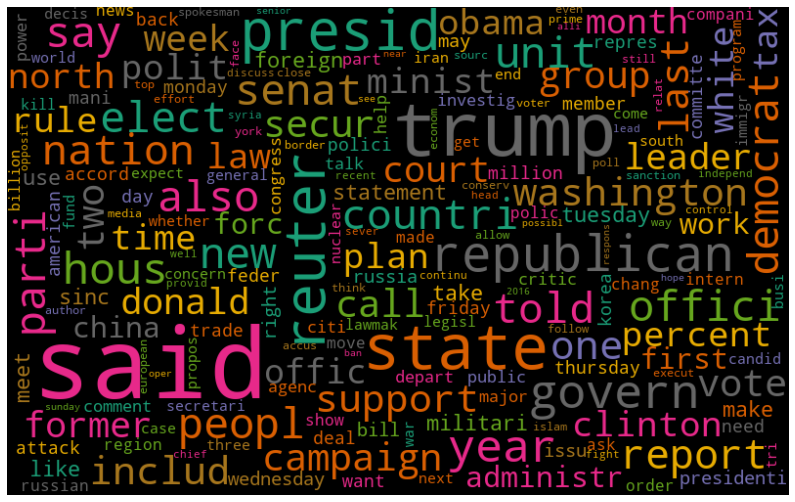

In [0]:
wordcloudConvertDF = frq_true.set_index('word_count').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Fake News WordCloud**

In [0]:
frq_fake = frequencies_lab[['word_count', 'count']].where(frequencies_lab['label'] == 'fake').dropna()

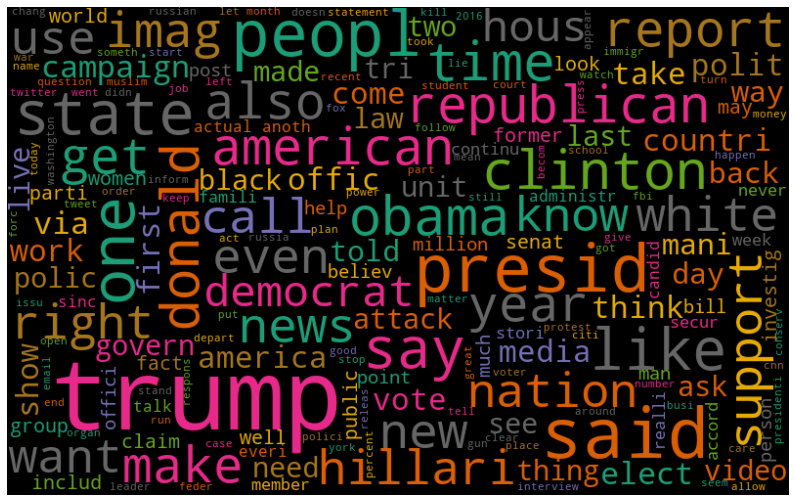

In [0]:
wordcloudConvertDF = frq_fake.set_index('word_count').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#**Modeling**

####**Logistic Regression**

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline


hashtf = HashingTF(inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=10) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "label_ind")
pipeline = Pipeline(stages=[ hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(news_final).transform(news_final)


In [0]:
(train_set, test_set) = pipelineFit.randomSplit([0.75, 0.25], seed = 2000)

**uni_gram: LR**

In [34]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label_ind', maxIter=100)
lrModel = lr.fit(train_set)
predictions = lrModel.transform(test_set)
predictions.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----+----------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----------+
|               title|          text_clean|         words_token|         words_clean|       words_stemmed|  subject|label| date_time|               words|                  tf|            features|label_ind|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----+----------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----------+
| Florida Voters K...|yesterday florida...|[yesterday, flori...|[yesterday, flori...|[yesterday, flori...|     News| fake|2016-08-31|[yesterday, flori...|(262144,[186,737,...|(262144,[186,737,...|      0.0|[31.2440878277

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol = 'label_ind')
evaluator.evaluate(predictions)

0.9858799705599572

In [36]:
accuracy = predictions.filter(predictions.label_ind == predictions.prediction).count() / float(test_set.count())
accuracy

0.9855595667870036

In [37]:
pipelineFit.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----+----------+--------------------+--------------------+--------------------+---------+
|               title|          text_clean|         words_token|         words_clean|       words_stemmed|  subject|label| date_time|               words|                  tf|            features|label_ind|
+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----+----------+--------------------+--------------------+--------------------+---------+
| Trump HUMILIATES...|donald trump sure...|[donald, trump, s...|[donald, trump, s...|[donald, trump, s...|     News| fake|2017-09-08|[donald, trump, s...|(262144,[865,5595...|(262144,[865,5595...|      0.0|
|MAXINE WATERS: Ob...|at around the 400...|[at, around, the,...|[around, 400, mar...|[around, 400, mar...|left-news| fake|2017-03-06|[around, 400, mar...|(262144,[4977,588.

In [39]:
from pyspark.sql.functions import count, avg
test_news = test_set.groupBy('label').agg(count('label'))
test_news.show()

+-----+------------+
|label|count(label)|
+-----+------------+
| fake|        2334|
| true|        2098|
+-----+------------+



**bi_gram: LR**

In [0]:

from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
 
def build_ngrams_m(inputCol="words", n=3):

    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    return Pipeline(stages=ngrams )

In [0]:
news_grams = build_ngrams_m().fit(news_final).transform(news_final)

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline


hashtf = HashingTF(inputCol="2_grams", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features_gram", minDocFreq=100) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "label_ind")
pipeline = Pipeline(stages=[ hashtf, idf, label_stringIdx])

pipelineFit_gram = pipeline.fit(news_grams).transform(news_grams)


In [0]:
(train_setg, val_setg, test_setg) = pipelineFit_gram.randomSplit([0.80, 0.10, 0.10], seed = 2000)

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features_gram', labelCol='label_ind', maxIter=100)
lrModelg = lr.fit(train_setg)
predictionsg = lrModelg.transform(test_setg)

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol = 'label_ind')
evaluator.evaluate(predictionsg)

0.9722044067593807

In [30]:
accuracyg = predictionsg.filter(predictionsg.label_ind == predictionsg.prediction).count() / float(test_setg.count())
accuracyg

0.9720216606498195

In [31]:
pipelineFit_gram.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|               title|          text_clean|         words_token|         words_clean|       words_stemmed|     subject|label| date_time|               words|             1_grams|             2_grams|                  tf|       features_gram|label_ind|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|HOLY WIDOWS AND O...|europe s new new ...|[europe, s, new, ...|[europe, new, new...|[europ, new, new,...|    politics| fake|2016-02-21|[europ, new, new,...|[europ, new, new,...|[europ new, new n...|(262144,[234,951,...|(262144,[234,951,...|   

**tri_gram: LR**

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
hashtf = HashingTF(inputCol="3_grams", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features_3gram", minDocFreq=100) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "label_ind")
pipeline = Pipeline(stages=[ hashtf, idf, label_stringIdx])

pipelineFit_3gram = pipeline.fit(news_grams).transform(news_grams)

In [0]:
(train_set3g, val_set3g, test_set3g) = pipelineFit_3gram.randomSplit([0.80, 0.10, 0.10], seed = 2000)

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features_3gram', labelCol='label_ind', maxIter=100)
lrModel3g = lr.fit(train_set3g)
predictions3g = lrModel3g.transform(test_set3g)

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol = 'label_ind')
evaluator.evaluate(predictions3g)

0.8736935946021643

##**Naive Bayes Model**

In [0]:
import pyspark.sql.functions as f
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
 
def build_ngrams3(inputCol="words", n=3):
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]
    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i))
        for i in range(1, n + 1)
    ]

    idf = [IDF(inputCol="{0}_counts".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]
    
    step = [StringIndexer(inputCol='category', outputCol="label").fit(bothnews)]
    return Pipeline(stages=ngrams + vectorizers + idf+step)

In [0]:
bothnews = news_final.select('words','label')
bothnews = bothnews.withColumnRenamed("label", "category")
combinedDF = build_ngrams3().fit(bothnews).transform(bothnews)
# combinedDF.show(10)

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator

**uni-gram: nb model**

In [50]:
train, test = combinedDF.randomSplit([0.75, 0.25], seed=12345)
nb = NaiveBayes(featuresCol='1_tfidf', labelCol='label', modelType="multinomial")
nbModel = nb.fit(train)
pred = nbModel.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.947761798142017


**bi-gram: nb model**

In [26]:
%%time
train, test = combinedDF.randomSplit([0.75, 0.25], seed=12345)
nb = NaiveBayes(featuresCol='2_tfidf', labelCol='label', modelType="multinomial")
nbModel = nb.fit(train)
pred = nbModel.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9739640286262996
CPU times: user 527 ms, sys: 174 ms, total: 701 ms
Wall time: 1h 11min 40s


**tri-gram: nb model**

In [27]:
%%time
train, test = combinedDF.randomSplit([0.75, 0.25], seed=12345)
nb = NaiveBayes(featuresCol='3_tfidf', labelCol='label', modelType="multinomial")
nbModel = nb.fit(train)
pred = nbModel.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9746372894637203
CPU times: user 540 ms, sys: 156 ms, total: 696 ms
Wall time: 1h 11min 24s


**Creating PipLine for Text Cleaning**

In [0]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="text_clean", outputCol="words", pattern="\\W")
# stop words
# add_stopwords = ["http","https","amp","rt","t","c","the"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [0]:

label_stringIdx = StringIndexer(inputCol = "label", outputCol = "label2")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------------------+--------------------+------+
|               title|                text|          text_clean|     subject|label| date_time|               words|            filtered|            features|label2|
+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------------------+--------------------+------+
|Kushner divests e...|NEW YORK (IFR) - ...|new york ifr  jar...|politicsNews| true|2017-01-31|[new, york, ifr, ...|[new, york, ifr, ...|(10000,[0,1,2,3,7...|   1.0|
| Obama Takes A Tr...|President Obama v...|president obama v...|        News| fake|2017-07-03|[president, obama...|[president, obama...|(10000,[0,1,2,3,4...|   0.0|
|WATCH RESPONSES B...|The answers to qu...|the answers to qu...|    politics| fake|2015-08-03|[the, answers, to...|[answers, questio...|(10000,[1,10,107,...|   0.0|
| On The D

In [0]:
dataset = dataset.withColumnRenamed("label", "t_f").withColumnRenamed("label2", "label")

In [0]:
dd3 = dataset.withColumnRenamed("label", "t_f").withColumnRenamed("label2", "label")
dd3.show(5)

+--------------------+--------------------+--------------------+------------+----+----------+--------------------+--------------------+--------------------+--------------------+-----+
|               title|                text|          text_clean|     subject| t_f| date_time|               words|            filtered|         rawFeatures|            features|label|
+--------------------+--------------------+--------------------+------------+----+----------+--------------------+--------------------+--------------------+--------------------+-----+
|Kushner divests e...|NEW YORK (IFR) - ...|new york ifr  jar...|politicsNews|true|2017-01-31|[new, york, ifr, ...|[new, york, ifr, ...|(10000,[70,157,30...|(10000,[70,157,30...|  1.0|
| Obama Takes A Tr...|President Obama v...|president obama v...|        News|fake|2017-07-03|[president, obama...|[president, obama...|(10000,[25,73,126...|(10000,[25,73,126...|  0.0|
|WATCH RESPONSES B...|The answers to qu...|the answers to qu...|    politics|fak

**Train and test data**

In [0]:
(trainingData, testData) = dd3.randomSplit([0.75, 0.25], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 31337
Test Dataset Count: 13339


**Logistic Regression using countvector feature**

In [0]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="text_clean", outputCol="words", pattern="\\W")
# stop words
# add_stopwords = ["http","https","amp","rt","t","c","the"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [0]:

label_stringIdx = StringIndexer(inputCol = "label", outputCol = "label2")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------------------+--------------------+------+
|               title|                text|          text_clean|     subject|label| date_time|               words|            filtered|            features|label2|
+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+--------------------+--------------------+------+
|Kushner divests e...|NEW YORK (IFR) - ...|new york ifr  jar...|politicsNews| true|2017-01-31|[new, york, ifr, ...|[new, york, ifr, ...|(10000,[0,1,2,3,7...|   1.0|
| Obama Takes A Tr...|President Obama v...|president obama v...|        News| fake|2017-07-03|[president, obama...|[president, obama...|(10000,[0,1,2,3,4...|   0.0|
|WATCH RESPONSES B...|The answers to qu...|the answers to qu...|    politics| fake|2015-08-03|[the, answers, to...|[answers, questio...|(10000,[1,10,107,...|   0.0|
| On The D

In [0]:
dataset = dataset.withColumnRenamed("label", "t_f").withColumnRenamed("label2", "label")

In [0]:
dd3 = dataset.withColumnRenamed("label", "t_f").withColumnRenamed("label2", "label")
dd3.show(5)

+--------------------+--------------------+--------------------+------------+----+----------+--------------------+--------------------+--------------------+--------------------+-----+
|               title|                text|          text_clean|     subject| t_f| date_time|               words|            filtered|         rawFeatures|            features|label|
+--------------------+--------------------+--------------------+------------+----+----------+--------------------+--------------------+--------------------+--------------------+-----+
|Kushner divests e...|NEW YORK (IFR) - ...|new york ifr  jar...|politicsNews|true|2017-01-31|[new, york, ifr, ...|[new, york, ifr, ...|(10000,[70,157,30...|(10000,[70,157,30...|  1.0|
| Obama Takes A Tr...|President Obama v...|president obama v...|        News|fake|2017-07-03|[president, obama...|[president, obama...|(10000,[25,73,126...|(10000,[25,73,126...|  0.0|
|WATCH RESPONSES B...|The answers to qu...|the answers to qu...|    politics|fak

Train and test data

In [0]:
(trainingData, testData) = dd3.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 31337
Test Dataset Count: 13339


Logistic Regression using count vector features

In [0]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text_clean","label","probability", "t_f","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+----+----------+
|                    text_clean|label|                   probability| t_f|prediction|
+------------------------------+-----+------------------------------+----+----------+
| in response to the establi...|  0.0|[0.9999999999998037,1.96232...|fake|       0.0|
|i just happened to be liste...|  0.0|[0.9999999999997102,2.89870...|fake|       0.0|
|shawn helton 21st century w...|  0.0|[0.9999999993161566,6.83843...|fake|       0.0|
|shawn helton 21st century w...|  0.0|[0.9999999993161566,6.83843...|fake|       0.0|
|  randy johnson 21st centur...|  0.0|[0.9999999992479027,7.52097...|fake|       0.0|
|it doesn t matter if you ha...|  0.0|[0.9999999990510862,9.48913...|fake|       0.0|
|shawn helton  21st century ...|  0.0|[0.9999999989642143,1.03578...|fake|       0.0|
|shawn helton  21st century ...|  0.0|[0.9999999989642143,1.03578...|fake|       0.0|
| your government thanks you...|  0.0|[0.9999999962137

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.987257447649875

In [0]:
trainingData.show(5)

+--------------------+--------------------+--------------------+-------+-----+----------+--------------------+--------------------+--------------------+--------------------+------+
|               title|                text|          text_clean|subject|label| date_time|               words|            filtered|         rawFeatures|            features|label2|
+--------------------+--------------------+--------------------+-------+-----+----------+--------------------+--------------------+--------------------+--------------------+------+
| #NeverTrump GOPe...|The #NeverTrump G...|the nevertrump go...|   News| fake|2016-08-08|[the, nevertrump,...|[nevertrump, gop,...|(10000,[76,120,12...|(10000,[76,120,12...|   0.0|
| After GOP Congre...|Hours after a gun...|hours after a gun...|   News| fake|2017-06-14|[hours, after, a,...|[hours, gunman, o...|(10000,[15,145,31...|(10000,[15,145,31...|   0.0|
| BUSTED: Guess Wh...|Oregon Public Bro...|oregon public bro...|   News| fake|2016-01-09|[orego

Logistic regression using td-idf features

In [0]:
dd3.show(5)

+--------------------+--------------------+--------------------+------------+----+----------+--------------------+--------------------+--------------------+--------------------+-----+
|               title|                text|          text_clean|     subject| t_f| date_time|               words|            filtered|         rawFeatures|            features|label|
+--------------------+--------------------+--------------------+------------+----+----------+--------------------+--------------------+--------------------+--------------------+-----+
|Kushner divests e...|NEW YORK (IFR) - ...|new york ifr  jar...|politicsNews|true|2017-01-31|[new, york, ifr, ...|[new, york, ifr, ...|(10000,[70,157,30...|(10000,[70,157,30...|  1.0|
| Obama Takes A Tr...|President Obama v...|president obama v...|        News|fake|2017-07-03|[president, obama...|[president, obama...|(10000,[25,73,126...|(10000,[25,73,126...|  0.0|
|WATCH RESPONSES B...|The answers to qu...|the answers to qu...|    politics|fak

In [0]:
from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dd3.randomSplit([0.75, 0.25], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text_clean","label","probability", "t_f","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+----+----------+
|                    text_clean|label|                   probability| t_f|prediction|
+------------------------------+-----+------------------------------+----+----------+
|i just happened to be liste...|  0.0|[0.9999999999962017,3.79827...|fake|       0.0|
| in response to the establi...|  0.0|[0.9999999999960776,3.92247...|fake|       0.0|
| jay dyer 21st century wire...|  0.0|[0.9999999999097777,9.02221...|fake|       0.0|
| your government thanks you...|  0.0|[0.9999999998524483,1.47551...|fake|       0.0|
|shawn helton  21st century ...|  0.0|[0.9999999975723317,2.42766...|fake|       0.0|
|shawn helton  21st century ...|  0.0|[0.9999999975723317,2.42766...|fake|       0.0|
|patrick henningsen 21st cen...|  0.0|[0.9999999911357337,8.86426...|fake|       0.0|
|  randy johnson 21st centur...|  0.0|[0.9999999880245408,1.19754...|fake|       0.0|
|shawn helton 21st century w...|  0.0|[0.9999999815102

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9862826894305676

Naive Bayes using tf-idf features

In [0]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text_clean","label","probability", "t_f","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+---------------------------+----+----------+
|                    text_clean|label|                probability| t_f|prediction|
+------------------------------+-----+---------------------------+----+----------+
|apparently this protester b...|  0.0|  [1.0,9.8765695038827E-17]|fake|       0.0|
| the shrill old socialist  ...|  0.0|[1.0,9.264732960778658E-17]|fake|       0.0|
|washington reuters  it was ...|  1.0|[1.0,8.801115673881618E-17]|true|       0.0|
|republicans finally rolled ...|  0.0| [1.0,8.79479243779789E-17]|fake|       0.0|
|the following statementswer...|  1.0|[1.0,8.287971507878172E-17]|true|       0.0|
|after the reid event hillar...|  0.0|[1.0,7.937736084499144E-17]|fake|       0.0|
| cia director john brennan ...|  0.0|[1.0,7.746363366190383E-17]|fake|       0.0|
| cia director john brennan ...|  0.0|[1.0,7.746363366190383E-17]|fake|       0.0|
|van jones praised president...|  0.0|[1.0,7.277589396919751E-17]|fake|       0.0|
|van

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.939998267201722

In [0]:
# lr_model_evaluator = MulticlassClassificationEvaluator(
#     labelCol="label", predictionCol="prediction", metricName="accuracy")

In [0]:
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

Accuracy = 0.939998


In [0]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text_clean","label","probability", "t_f","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+----+----------+
|                    text_clean|label|                   probability| t_f|prediction|
+------------------------------+-----+------------------------------+----+----------+
| in response to the establi...|  0.0|[0.9999999999998037,1.96232...|fake|       0.0|
|i just happened to be liste...|  0.0|[0.9999999999997102,2.89870...|fake|       0.0|
|shawn helton 21st century w...|  0.0|[0.9999999993161566,6.83843...|fake|       0.0|
|shawn helton 21st century w...|  0.0|[0.9999999993161566,6.83843...|fake|       0.0|
|  randy johnson 21st centur...|  0.0|[0.9999999992479027,7.52097...|fake|       0.0|
|it doesn t matter if you ha...|  0.0|[0.9999999990510862,9.48913...|fake|       0.0|
|shawn helton  21st century ...|  0.0|[0.9999999989642143,1.03578...|fake|       0.0|
|shawn helton  21st century ...|  0.0|[0.9999999989642143,1.03578...|fake|       0.0|
| your government thanks you...|  0.0|[0.9999999962137

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.987257447649875

In [0]:
trainingData.show(5)

+--------------------+--------------------+--------------------+-------+-----+----------+--------------------+--------------------+--------------------+--------------------+------+
|               title|                text|          text_clean|subject|label| date_time|               words|            filtered|         rawFeatures|            features|label2|
+--------------------+--------------------+--------------------+-------+-----+----------+--------------------+--------------------+--------------------+--------------------+------+
| #NeverTrump GOPe...|The #NeverTrump G...|the nevertrump go...|   News| fake|2016-08-08|[the, nevertrump,...|[nevertrump, gop,...|(10000,[76,120,12...|(10000,[76,120,12...|   0.0|
| After GOP Congre...|Hours after a gun...|hours after a gun...|   News| fake|2017-06-14|[hours, after, a,...|[hours, gunman, o...|(10000,[15,145,31...|(10000,[15,145,31...|   0.0|
| BUSTED: Guess Wh...|Oregon Public Bro...|oregon public bro...|   News| fake|2016-01-09|[orego

**Logistic regression using td-idf features**

In [0]:
dd3.show(5)

+--------------------+--------------------+--------------------+------------+----+----------+--------------------+--------------------+--------------------+--------------------+-----+
|               title|                text|          text_clean|     subject| t_f| date_time|               words|            filtered|         rawFeatures|            features|label|
+--------------------+--------------------+--------------------+------------+----+----------+--------------------+--------------------+--------------------+--------------------+-----+
|Kushner divests e...|NEW YORK (IFR) - ...|new york ifr  jar...|politicsNews|true|2017-01-31|[new, york, ifr, ...|[new, york, ifr, ...|(10000,[70,157,30...|(10000,[70,157,30...|  1.0|
| Obama Takes A Tr...|President Obama v...|president obama v...|        News|fake|2017-07-03|[president, obama...|[president, obama...|(10000,[25,73,126...|(10000,[25,73,126...|  0.0|
|WATCH RESPONSES B...|The answers to qu...|the answers to qu...|    politics|fak

In [0]:
from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dd3.randomSplit([0.75, 0.25], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text_clean","label","probability", "t_f","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+----+----------+
|                    text_clean|label|                   probability| t_f|prediction|
+------------------------------+-----+------------------------------+----+----------+
|i just happened to be liste...|  0.0|[0.9999999999962017,3.79827...|fake|       0.0|
| in response to the establi...|  0.0|[0.9999999999960776,3.92247...|fake|       0.0|
| jay dyer 21st century wire...|  0.0|[0.9999999999097777,9.02221...|fake|       0.0|
| your government thanks you...|  0.0|[0.9999999998524483,1.47551...|fake|       0.0|
|shawn helton  21st century ...|  0.0|[0.9999999975723317,2.42766...|fake|       0.0|
|shawn helton  21st century ...|  0.0|[0.9999999975723317,2.42766...|fake|       0.0|
|patrick henningsen 21st cen...|  0.0|[0.9999999911357337,8.86426...|fake|       0.0|
|  randy johnson 21st centur...|  0.0|[0.9999999880245408,1.19754...|fake|       0.0|
|shawn helton 21st century w...|  0.0|[0.9999999815102

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9862826894305676

**Naive Bayes using tf-idf features**

In [0]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text_clean","label","probability", "t_f","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+---------------------------+----+----------+
|                    text_clean|label|                probability| t_f|prediction|
+------------------------------+-----+---------------------------+----+----------+
|apparently this protester b...|  0.0|  [1.0,9.8765695038827E-17]|fake|       0.0|
| the shrill old socialist  ...|  0.0|[1.0,9.264732960778658E-17]|fake|       0.0|
|washington reuters  it was ...|  1.0|[1.0,8.801115673881618E-17]|true|       0.0|
|republicans finally rolled ...|  0.0| [1.0,8.79479243779789E-17]|fake|       0.0|
|the following statementswer...|  1.0|[1.0,8.287971507878172E-17]|true|       0.0|
|after the reid event hillar...|  0.0|[1.0,7.937736084499144E-17]|fake|       0.0|
| cia director john brennan ...|  0.0|[1.0,7.746363366190383E-17]|fake|       0.0|
| cia director john brennan ...|  0.0|[1.0,7.746363366190383E-17]|fake|       0.0|
|van jones praised president...|  0.0|[1.0,7.277589396919751E-17]|fake|       0.0|
|van

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.939998267201722

In [0]:
# lr_model_evaluator = MulticlassClassificationEvaluator(
#     labelCol="label", predictionCol="prediction", metricName="accuracy")

In [0]:
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

Accuracy = 0.939998


**LSVM Models**

In [0]:
import pyspark.sql.functions as f
# news_text_fake = news_final.where(f.col("label").isin({"fake"})).select('words','label')
# news_text_true = news_final.where(f.col("label").isin({"true"})).select('words','label')

from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
 
def build_tf(inputCol="words", n=3):

    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i))
        for i in range(1, n + 1)
    ]

    idf = [IDF(inputCol="{0}_counts".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]
    
    step = [StringIndexer(inputCol='category', outputCol="label").fit(bothnews)]
    # assembler = [VectorAssembler(
    #     inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
    #     outputCol="features"
    # )]

    return Pipeline(stages=ngrams + vectorizers + idf+step)



In [0]:
bothnews = news_final.select('words','label')
bothnews = bothnews.withColumnRenamed("label", "category")
combinedDF = build_tf().fit(bothnews).transform(bothnews)
combinedDF.show(10)

+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|               words|category|             1_grams|             2_grams|             3_grams|            1_counts|            2_counts|            3_counts|             1_tfidf|             2_tfidf|             3_tfidf|label|
+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|[geneva, reuter, ...|    true|[geneva, reuter, ...|[geneva reuter, r...|[geneva reuter hu...|(197096,[0,3,6,8,...|(262144,[33,34,67...|(262144,[216,426,...|(197096,[0,3,6,8,...|(262144,[33,34,67...|(262144,[216,426,...|  1.0|
|[easili, said, do...|    fake|[easili, said, do...|[easili said, sai...|[easili said dona..

In [0]:
# LSVM model
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def LSVMmodel(data, tst = .75, trn = .25):
  train, test = data.randomSplit([tst, trn], seed=12345)
  lsvc = LinearSVC(maxIter=10, regParam=0.1)
  lsvcModel = lsvc.fit(train)

  pred = lsvcModel.transform(test)
  evaluator = BinaryClassificationEvaluator()
  print('Test Area Under ROC', evaluator.evaluate(pred))
  # return testoutput

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

for n in range(1,4):
  # select tfidf and label columns
  combDF = combinedDF.select("{0}_tfidf".format(n), "label")
  combDF = combDF.withColumnRenamed("{0}_tfidf".format(n), "features")
  print(LSVMmodel(combDF))

Test Area Under ROC 0.9980737816833687
None
Test Area Under ROC 0.9966136776457434
None
Test Area Under ROC 0.9937508149921487
None
